In [1]:
import pandas as pd
import gc
import numpy as np
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# pd.set_option('display.float_format', '{:.10f}'.format)
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
train = pd.read_csv('./data/train.csv')
historical_transactions = pd.read_csv('./data/historical_transactions.csv')
new_merchant_transactions = pd.read_csv('./data/new_merchant_transactions.csv')
all_transactions = pd.concat([historical_transactions, new_merchant_transactions], axis=0)

In [3]:
from sklearn.preprocessing import LabelEncoder

In [4]:
all_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [6]:
all_transactions.isnull().sum()

authorized_flag               0
card_id                       0
city_id                       0
category_1                    0
installments                  0
category_3               234081
merchant_category_id          0
merchant_id              164697
month_lag                     0
purchase_amount               0
purchase_date                 0
category_2              2764609
state_id                      0
subsector_id                  0
dtype: int64

In [7]:
all_transactions[all_transactions.merchant_id.isnull()].head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
43,Y,C_ID_4e6213e9bc,-1,N,0,A,278,NaN,0,-0.719154,2018-02-24 10:52:32,NaN,-1,37
82,Y,C_ID_4e6213e9bc,-1,N,0,A,278,NaN,0,-0.713173,2018-02-25 12:07:37,NaN,-1,37
153,Y,C_ID_4e6213e9bc,-1,N,0,A,278,NaN,0,-0.702159,2018-02-10 12:30:44,NaN,-1,37
260,Y,C_ID_4e6213e9bc,-1,N,0,A,278,NaN,0,-0.713053,2018-02-11 12:10:48,NaN,-1,37
274,Y,C_ID_4e6213e9bc,-1,N,0,A,278,NaN,0,-0.703121,2018-02-13 13:08:38,NaN,-1,37


In [8]:
all_transactions["merchant_id"] = all_transactions.merchant_id.fillna("nan")
m_ecd = LabelEncoder()
all_transactions["m_code"] = m_ecd.fit_transform(all_transactions.merchant_id)

In [17]:
m_seq = all_transactions.groupby("card_id").m_code.agg(lambda x: list(x))

In [18]:
m_seq.head()

card_id
C_ID_00007093c1    [193597, 213289, 27975, 173570, 114591, 108746...
C_ID_0001238066    [82514, 273814, 273814, 273814, 228204, 273814...
C_ID_0001506ef0    [193151, 232545, 89630, 194167, 193067, 232545...
C_ID_0001793786    [251029, 88865, 106485, 277523, 169563, 104897...
C_ID_000183fdda    [854, 68894, 99419, 320165, 134554, 151596, 20...
Name: m_code, dtype: object

In [32]:
m_seq.reset_index(name="m_seq").head()

,card_id,m_seq
0,C_ID_00007093c1,"[193597, 213289, 27975, 173570, 114591, 108746..."
1,C_ID_0001238066,"[82514, 273814, 273814, 273814, 228204, 273814..."
2,C_ID_0001506ef0,"[193151, 232545, 89630, 194167, 193067, 232545..."
3,C_ID_0001793786,"[251029, 88865, 106485, 277523, 169563, 104897..."
4,C_ID_000183fdda,"[854, 68894, 99419, 320165, 134554, 151596, 20..."


In [33]:
data = m_seq.reset_index(name="m_seq")
data["target"] = data.card_id.map(train.set_index("card_id").target)

In [34]:
data.head()

,card_id,m_seq,target
0,C_ID_00007093c1,"[193597, 213289, 27975, 173570, 114591, 108746...",0.134077
1,C_ID_0001238066,"[82514, 273814, 273814, 273814, 228204, 273814...",NaN
2,C_ID_0001506ef0,"[193151, 232545, 89630, 194167, 193067, 232545...",0.884295
3,C_ID_0001793786,"[251029, 88865, 106485, 277523, 169563, 104897...",NaN
4,C_ID_000183fdda,"[854, 68894, 99419, 320165, 134554, 151596, 20...",-0.264433


In [35]:
train["m_seq"] = train.card_id.map(data.set_index("card_id").m_seq)

In [36]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target,m_seq
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283,"[267374, 263887, 71615, 240053, 223947, 234966..."
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913,"[177156, 24096, 224858, 184353, 311572, 324720..."
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056,"[112441, 112441, 112441, 112441, 30589, 112441..."
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495,"[63356, 111174, 75257, 45274, 30574, 94223, 19..."
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749,"[854, 270396, 270396, 237185, 270396, 228751, ..."


In [37]:
from data_io import load_test

In [38]:
test = load_test()

In [40]:
test["m_seq"] = test.card_id.map(data.set_index("card_id").m_seq)

In [42]:
train[["card_id", "m_seq", "target"]].to_csv("./data/train_m_seq.csv", index=False)
test[["card_id", "m_seq"]].to_csv("./data/test_m_seq.csv", index=False)

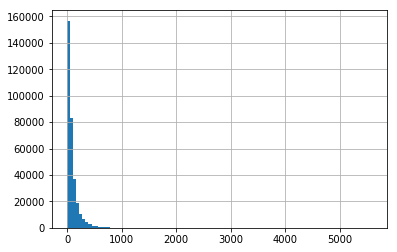

In [21]:
m_seq.apply(lambda x: len(x)).hist(bins=100)

In [43]:
train2 = pd.read_csv("./data/train_m_seq.csv")

In [45]:
train2.head()

,card_id,m_seq,target
0,C_ID_92a2005557,"[267374, 263887, 71615, 240053, 223947, 234966...",-0.820283
1,C_ID_3d0044924f,"[177156, 24096, 224858, 184353, 311572, 324720...",0.392913
2,C_ID_d639edf6cd,"[112441, 112441, 112441, 112441, 30589, 112441...",0.688056
3,C_ID_186d6a6901,"[63356, 111174, 75257, 45274, 30574, 94223, 19...",0.142495
4,C_ID_cdbd2c0db2,"[854, 270396, 270396, 237185, 270396, 228751, ...",-0.159749


In [55]:
train2.m_seq.head().apply(lambda x: [int(e) for e in x.strip("[]").split(",")])

0    [267374, 263887, 71615, 240053, 223947, 234966...
1    [177156, 24096, 224858, 184353, 311572, 324720...
2    [112441, 112441, 112441, 112441, 30589, 112441...
3    [63356, 111174, 75257, 45274, 30574, 94223, 19...
4    [854, 270396, 270396, 237185, 270396, 228751, ...
Name: m_seq, dtype: object

In [24]:
## some config values 
embed_size = 300 # how big is each word vector
max_features = 40000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 200 # max number of words in a question to use

In [61]:
train_X = train.m_seq[:10000].values
train_X = pad_sequences(train_X, maxlen=maxlen)
train_y = train.target[:10000].values

val_X = train.m_seq[10000:15000].values
val_X = pad_sequences(val_X, maxlen=maxlen)
val_y = train.target[10000:15000].values

In [59]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)
x = Bidirectional(CuDNNGRU(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="linear")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

In [60]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 300)          12000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 128)          140544    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total para

In [68]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger

model_filepath = "./notebook035-test.h5"
log_filepath = "./notebook035-test.csv"

metric_name = "mean_squared_error"
early_stopping = EarlyStopping(monitor=metric_name, mode='min', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(model_filepath, monitor=metric_name, mode='min', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor=metric_name, mode='min', factor=0.5, patience=6, min_lr=0.000005, verbose=1)  # patience=5, factor=0.2
model_logger = CSVLogger(log_filepath, separator=',', append=False)

In [70]:
model.fit(train_X, train_y,
          batch_size=512, epochs=5,
          validation_data=(val_X, val_y),
          callbacks=[early_stopping, model_checkpoint, model_logger],
          verbose=200)

Train on 10000 samples, validate on 5000 samples
Epoch 1/5

Epoch 00001: mean_squared_error improved from 13.20754 to 13.15269, saving model to ./notebook035-test.h5
Epoch 2/5

Epoch 00002: mean_squared_error improved from 13.15269 to 13.14785, saving model to ./notebook035-test.h5
Epoch 3/5

Epoch 00003: mean_squared_error did not improve from 13.14785
Epoch 4/5

Epoch 00004: mean_squared_error did not improve from 13.14785
Epoch 5/5

Epoch 00005: mean_squared_error did not improve from 13.14785


In [66]:
train_pred = model.predict(train_X)

In [72]:
train_pred.reshape((len(train_pred,)))

array([-0.5910566 , -0.2399218 , -0.3666911 , ..., -0.56573266,
       -0.30850887, -0.13979626], dtype=float32)

In [71]:
np.sqrt(13.14785)

3.6259964147803565

In [64]:
3.66 ** 2

13.395600000000002